# Generating Music with an RNN and Custom VAE

This notebook uses the MAESTRO dataset, which is approximately 1200 MIDI files of skilled pianists improvising. 

I first perform some data cleaning to transform the MIDI files into a format usable by a neural network. Each note event in a given MIDI is extracted from the MIDI and its pitch, velocity, duration, and difference in start time from the previous note in the MIDI (denoted step) are recorded. This greatly compresses the overall size of the data, but an optimal loss function is not obvious in this case. In this notebook, I treat pitch as categorical and sum that crossentropy with the MSE for step and duration. Other approaches to consider include discretizing the output space (e.g. into .01 second intervals) and predicting which notes are played at each interval, or fitting a convolutional model onto the pianoroll / matrix representation of the MIDIs: these both have much more intuitive and ostensibly effective loss functions, but incur a greater cost in computation.

Each notes' pitch, step, and duration are scaled to a standard normal (fit on the training data). This speeds up training and is generally a good practice. Although min-max scaling variables was also considered, the maximal step and duration values in the training data are very large (e.g., greater than 10 once scaled to N(0, 1)) and so min-max scaling would not fare well given those outliers.

I first fit an RNN which attempts to predict the next note given a sequence of previous notes. This is similar to a guide on the TensorFlow website, but with the previous (what I would hope are) improvements, and the addition of a custom generator which only considers notes which are at least *p* notes into the song when predicting based on the sequence of previous *p* notes. This generator is faster (at least on my computer) than the datasets from the TensorFlow guide, while also not using sequences with notes from 2 unrelated songs. Additionally, the generator allows model input values for pitch which are scaled to N(0, 1) and model output values which are in integer representation which allows treating the predictions for pitch as categorical values.

I next fit a hierarchal decoder which is essentially a much smaller version of MusicVAE. MusicVAE is a very large model and I don't anticipate being able to replicate its results without extensive model training, but the point of this exercise was to implement a custom model, and I hope to be able to generate music which is at least somewhat realistic. 

In [1]:
import os

import collections
import datetime
import fluidsynth
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import absl.logging

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import time
import re
import math

from tensorflow.keras.layers import (Bidirectional, Concatenate, Dense, Dropout, Flatten, 
                                     Input, Lambda, LSTM, LSTMCell, Reshape 
                                    )
from tensorflow.keras.regularizers import L2

In [2]:
seed = 7
tf.random.set_seed(seed)
np.random.seed(seed)

SAMPLING_RATE = 16000

In [3]:
# Root data directory
MAESTRO_DATA_ROOT_DIR = 'C:/_local/data_sets/audio/maestro_v3.0.0_midi/'

# Sub-directories for each data split
MAESTRO_TRAIN_DIR = MAESTRO_DATA_ROOT_DIR + 'train/'
MAESTRO_VALID_DIR = MAESTRO_DATA_ROOT_DIR + 'validation/'
MAESTRO_TEST_DIR = MAESTRO_DATA_ROOT_DIR + 'test/'

# Collection of paths for each data split
MAESTRO_TRAIN_MIDI_PATHS = np.array([MAESTRO_TRAIN_DIR+f for f in os.listdir(MAESTRO_TRAIN_DIR)])
MAESTRO_VALID_MIDI_PATHS = np.array([MAESTRO_VALID_DIR+f for f in os.listdir(MAESTRO_VALID_DIR)])
MAESTRO_TEST_MIDI_PATHS = np.array([MAESTRO_TEST_DIR+f for f in os.listdir(MAESTRO_TEST_DIR)])

In [65]:
# Root directory for project
PROJECT_DIR = 'C:/_local/py/maestro_rnn/'

# Individual directories for each model
MODEL_DIR = PROJECT_DIR + 'models/'
RNN_DIR = PROJECT_DIR + 'rnn/'
VAE_DIR = MODEL_DIR + 'vae/'
VAE_RNN_HIERARCHAL_DIR = PROJECT_DIR + 'vae_rnn_hierarchal/'

# Individual directories for outputs of each type of model
OUTPUT_DIR = PROJECT_DIR + 'outputs/'
RNN_OUTPUT = OUTPUT_DIR + 'rnn/'
VAE_OUTPUT = OUTPUT_DIR + 'vae/'
VAE_RNN_HIERARCHAL_OUTPUT = OUTPUT_DIR + 'vae_rnn_hierarchal/'

TEMP_OUTPUT_PATH = OUTPUT_DIR + 'temp.mid'

In [5]:
print(f'number of training midids: {len(MAESTRO_TRAIN_MIDI_PATHS)}')
print(f'number of validation midis: {len(MAESTRO_VALID_MIDI_PATHS)}')
print(f'number of testing midids: {len(MAESTRO_TEST_MIDI_PATHS)}')

num_sample_train_midi_paths = 5
print(f'\nfirst {num_sample_train_midi_paths} train paths:')
for path in MAESTRO_TRAIN_MIDI_PATHS[:num_sample_train_midi_paths]:
    print(f'  {path}')

number of training midids: 962
number of validation midis: 137
number of testing midids: 177

first 5 train paths:
  C:/_local/data_sets/audio/maestro_v3.0.0_midi/train/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3.mid
  C:/_local/data_sets/audio/maestro_v3.0.0_midi/train/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2.mid
  C:/_local/data_sets/audio/maestro_v3.0.0_midi/train/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.mid
  C:/_local/data_sets/audio/maestro_v3.0.0_midi/train/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--3.mid
  C:/_local/data_sets/audio/maestro_v3.0.0_midi/train/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--5.mid


In [6]:
# Utility functions
##### ---------------------------------------------------------------------------------------------------------------- #####

# Use IPython display to display audio from MIDI
def display_audio(pm, seconds=30):
    global SAMPLING_RATE
    waveform = pm.fluidsynth(fs=SAMPLING_RATE)
    waveform_short = waveform[:seconds*SAMPLING_RATE]    
    return display.Audio(waveform_short, rate=SAMPLING_RATE)

# Use IPython display to display audio from MIDI path
def display_audio_from_path(midi_path, seconds=30):
    pm = pretty_midi.PrettyMIDI(midi_path)
    return display_audio(midi_path, seconds)

# Play MIDI auido
def play_midi(midi, time_s=10, temp_path=TEMP_OUTPUT_PATH):
    assert isinstance(midi, pretty_midi.PrettyMIDI), 'midi is not PrettyMIDI'
    midi.write(temp_path)
    pygame.mixer.init()
    pygame.mixer.music.load(temp_path)
    pygame.mixer.music.play()
    time.sleep(time_s)
    pygame.mixer.music.stop()
    
# Extract note events from MIDI file into DataFrame
def midi_to_notes(midi_file, time_discretization_constant=0, max_step_and_duration=np.Inf):
    
    # All notes must have start and end times which are integer multiples of time_discretization_constant
    # By implication, each notes' step and duration are integer multiples of time_discretization_constant
    
    if isinstance(midi_file, str):
        pm = pretty_midi.PrettyMIDI(midi_file)
    elif isinstance(midi_file, pretty_midi.PrettyMIDI):
        pm = midi_file
        
    instrument = pm.instruments[0]
    notes = {'start': [], 'end': [], 'pitch': [], 'velocity': [], 'step': [], 'duration': []}
    
    raw_notes = instrument.notes
    
    new_notes = []
    note_ids = []
    
    # Break notes with duration > max_step_and_duration into smaller consecutive notes
    if max_step_and_duration != np.Inf:
        for note_id, raw_note in enumerate(raw_notes):
            raw_duration = raw_note.end - raw_note.start
            
            if raw_duration > max_step_and_duration:
                shard_start = raw_note.start
                
                while shard_start < raw_note.end:
                    time_to_add = min(raw_note.end - shard_start, max_step_and_duration)
                    
                    new_raw_note = pretty_midi.Note(
                        pitch=raw_note.pitch, velocity=raw_note.velocity, start=shard_start, end=shard_start+time_to_add
                    )
                    
                    
                    new_notes.append(new_raw_note)
                    shard_start += time_to_add
                    
                note_ids.append(note_id)
    
    subset_raw_notes = [note for rid, note in enumerate(raw_notes) if not rid in note_ids]
    raw_notes = np.concatenate([subset_raw_notes, new_notes], axis=0)
    
    # Sort notes by start
    sorted_notes = sorted( raw_notes, key=lambda note: note.start )
    
    if time_discretization_constant != 0:
        prev_start = (sorted_notes[0].start // time_discretization_constant) * time_discretization_constant
    else:
        prev_start = sorted_notes[0].start
                
    for note in sorted_notes:
        
        if time_discretization_constant != 0:
            
            note_start = (note.start // time_discretization_constant) * time_discretization_constant
            note_end = (note.end // time_discretization_constant) * time_discretization_constant
                
        else:
            
            note_start = note.start
            note_end = note.end
            
        note_step = note_start - prev_start
            
        # If note_step > max_step, then break the silence into note_step // max_step silent notes
        # plus remainer note with step note_step % max_step
        num_max_steps_to_take = note_step // max_step_and_duration
        for s in range(int(num_max_steps_to_take)):
            
            start = prev_start + s*max_step_and_duration
            end = start + max_step_and_duration
            
            notes['start'].append(start)
            notes['end'].append(end)
            notes['pitch'].append(note.pitch)
            notes['velocity'].append(note.velocity)
            notes['step'].append(max_step_and_duration)
            notes['duration'].append(max_step_and_duration)
                        
            note_step -= max_step_and_duration
        
        note_duration = note_end - note_start
            
        notes['start'].append(note_start)
        notes['end'].append(note_end)
        notes['pitch'].append(note.pitch)
        notes['velocity'].append(note.velocity)
        notes['step'].append(note_step)
        notes['duration'].append(note_duration)
            
        prev_start = note_start
        
    notes_df = pd.DataFrame({name: np.array(value) for name, value in notes.items()})

    return notes_df       
        

# Plot piano roll from notes DataFrame
def plot_piano_roll(notes, count=0):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)
    
# Plot distributions of note values in DataFrame
def plot_distributions(_notes, drop_percentile=2.5, pitch_diff=0, pitch_scale=128, title=None):
    # Drop percentile keeps distribution bins from being influenced by outliers
    notes = _notes.copy()
    if 'velocity' in notes.columns:
                
        fig, axs = plt.subplots(2, 2, figsize=(13, 7)) 
        plt.subplots_adjust(hspace=.3)
        
        sns.histplot(notes, x='pitch', bins=20, ax=axs[0, 0])
        axs[0, 0].set_title('pitch')
        axs[0, 0].set_xlabel('')
        
        max_step = np.percentile(notes['step'], 100 - drop_percentile)
        sns.histplot(notes, x='step', bins=np.linspace(0, max_step, 21), ax=axs[0, 1])
        axs[0, 1].set_title('step')
        axs[0, 1].set_ylabel('')
        axs[0, 1].set_xlabel('')
        
        max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
        sns.histplot(notes, x='duration', bins=np.linspace(0, max_duration, 21), ax=axs[1, 0])
        axs[1, 0].set_title('duration')
        axs[1, 0].set_xlabel('')
        
        max_velocity = np.percentile(notes['velocity'], 100 - drop_percentile)
        sns.histplot(notes, x='velocity', ax=axs[1, 1])  
        axs[1, 1].set_title('velocity')
        axs[1, 1].set_ylabel('')
        axs[1, 1].set_xlabel('')
        
    else:
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.subplots_adjust(wspace=.25)
        
        sns.histplot(notes, x=list(notes['pitch']), bins=20, stat='count', ax=axs[0])
        axs[0].set_title('pitch')

        max_step = np.percentile(notes['step'], 100 - drop_percentile)
        sns.histplot(notes, x=list(notes['step']), bins=np.linspace(0, max_step, 21), stat='count', ax=axs[1])
        axs[1].set_title('step')
        axs[1].set_ylabel('')
        
        max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
        sns.histplot(notes, x=list(notes['duration']), bins=np.linspace(0, max_duration, 21), stat='count', ax=axs[2])
        axs[2].set_title('duration')
        axs[2].set_ylabel('')
        
    if title is not None:
        fig.suptitle(f'{title}')
        
def notes_windowed_to_notes_raw(notes):
    
    assert set(notes.columns) == {'pitch', 'step', 'duration', 'velocity'}
    
    raw_dict = {'start': [], 'end': [], 'pitch': [], 'velocity': []}
    prev_note_start = 0
    for _, note in notes.iterrows():
        
        note_start = prev_note_start + note['step']
        note_end = note_start + note['duration']
        
        raw_dict['start'].append(note_start)
        raw_dict['end'].append(note_end)
        raw_dict['pitch'].append(note['pitch'])
        raw_dict['velocity'].append(note['velocity'])
        
        prev_note_start += note['step']
        
    return pd.DataFrame(raw_dict).sort_values(by=['start'])
        
# Convert DataFrame of notes to MIDI file
def notes_to_midi(notes, instrument_program, save, out_file=TEMP_OUTPUT_PATH, constant_velocity=77):
        
    assert 'pitch' in notes.columns
    assert 'velocity' in notes.columns or constant_velocity != 0, 'need a velocity value'
    
    start_end = 'start' in notes.columns and 'end' in notes.columns
    step_dur = 'step' in notes.columns and 'duration' in notes.columns
    assert start_end or step_dur, 'notes must have either (start, end) or (step, duration)'
    
    pm = pretty_midi.PrettyMIDI()
    
    if isinstance(instrument_program, str):
        instrument_program = pretty_midi.instrument_name_to_program(instrument_program)
        
    instrument = pretty_midi.Instrument(program=instrument_program)

    prev_start = 0
    for _, note in notes.iterrows():
        if 'start' not in notes.columns:
            note_start = float(prev_start + note['step'])
        else:
            note_start = note['start']
        if 'end' not in notes.columns:
            note_end = float(note_start + note['duration'])
        else:
            note_end = note['end']
        if 'velocity' not in note.index:
            note_velocity = constant_velocity
        else:
            note_velocity = note['velocity']           
        
        note = pretty_midi.Note(velocity=round(note_velocity), pitch=round(note['pitch']), start=note_start, end=note_end)
        instrument.notes.append(note)
        prev_start = note_start
                
    pm.instruments.append(instrument)
    if save:
        pm.write(out_file)
    return pm

# Create DataFrame of notes from MIDI path(s)
def create_note_dataframe(midi_paths, keys, sequence_length, 
                          time_discretization_constant=0, max_step_and_duration=np.Inf, 
                          num_files_total=0, num_files_fraction=0):
    
    assert num_files_total != 0 or num_files_fraction != 0, 'specify number of files'
    
    total_num_paths = len(midi_paths)
    
    if num_files_fraction != 0:
        num_files = np.ceil(total_num_paths * num_files_fraction)
    else:
        num_files = num_files_total
    
    file_idx = np.random.choice(np.arange(total_num_paths), size=num_files, replace=False)
    file_idx = sorted(file_idx)
    
    midi_paths_subset = midi_paths[file_idx]
    
    all_notes = []
    for s, f in enumerate(midi_paths_subset):
        
        notes = midi_to_notes(f, time_discretization_constant, max_step_and_duration)
        
        # Add a flag indicating whether a note in a given song is within sequence_length of the song beginning        
        notes['song_beginning'] = ([1] * sequence_length) + ([0] * (notes.shape[0] - sequence_length))
        
        all_notes.append(notes)
        
    notes_df = pd.concat(all_notes, axis=0, ignore_index=True).drop_duplicates()
    notes_df = notes_df[keys]
    return notes_df       

### Sample Data Inspection

In [7]:
sample_pretty_midi = pretty_midi.PrettyMIDI(MAESTRO_TRAIN_MIDI_PATHS[0])
sample_midi_instrument = sample_pretty_midi.instruments[0]
sample_midi_instrument_name = pretty_midi.program_to_instrument_name(sample_midi_instrument.program)

print('Number of instruments:', len(sample_pretty_midi.instruments))
print('Instrument name:', sample_midi_instrument_name)

INSTRUMENT_NAME = sample_midi_instrument_name

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [8]:
raw_notes_sample = midi_to_notes(sample_pretty_midi, max_step_and_duration=1.3)
raw_notes_sample.head()

,start,end,pitch,velocity,step,duration
0,1.020833,1.214844,38,65,0.000000,0.194010
1,1.062500,1.247396,41,68,0.041667,0.184896
2,1.110677,1.259115,45,72,0.048177,0.148438
3,1.153646,1.276042,50,82,0.042969,0.122396
4,1.167969,1.281250,62,68,0.014323,0.113281


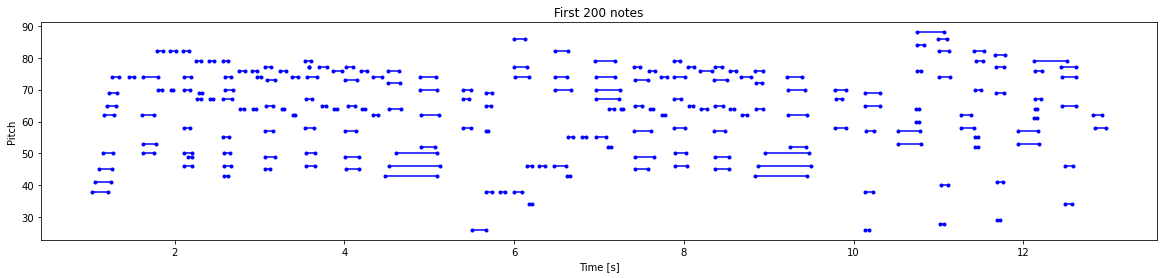

In [9]:
# Plot first num_sample_notes notes
num_sample_notes = 200
plot_piano_roll(raw_notes_sample, count=num_sample_notes)
display_audio(sample_pretty_midi, 15)

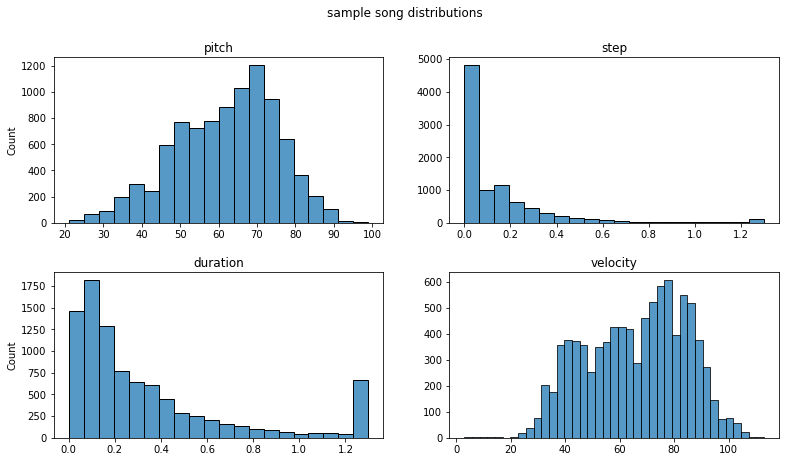

In [10]:
plot_distributions(raw_notes_sample, 0, title='sample song distributions')

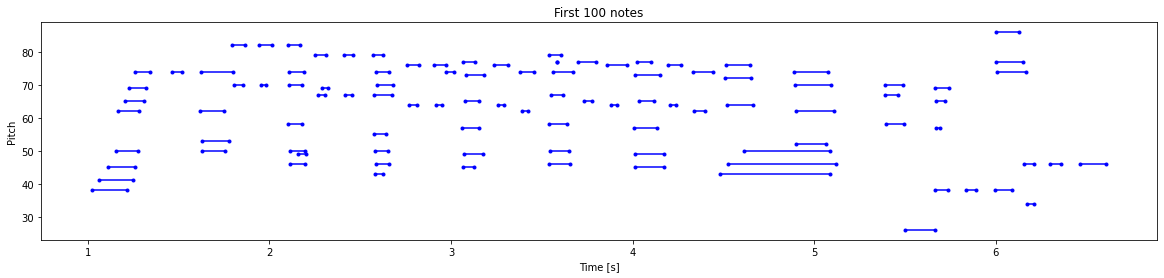

In [11]:
sample_midi_reconstructed = notes_to_midi(raw_notes_sample.iloc[:100], 0, False)
plot_piano_roll(raw_notes_sample, 100)
display_audio(sample_midi_reconstructed, 15)

## Creating Training Data

In [12]:
%%time

CONSTANT_VELOCITY = 77
SEQUENCE_LENGTH = 25
BATCH_SIZE = 32
PITCH_BOUNDS = (21, 109)
MAX_VELOCITY = 127
KEYS = ['pitch', 'step', 'duration', 
        #'velocity', 
        'song_beginning']

num_training_files = 5
num_validation_files = 1
num_testing_files = 1

np.random.seed(33)

training_df_raw = create_note_dataframe(
    MAESTRO_TRAIN_MIDI_PATHS, KEYS, SEQUENCE_LENGTH, num_files_total=num_training_files, #max_step_and_duration=1.0, 
)

validation_df_raw = create_note_dataframe(
    MAESTRO_VALID_MIDI_PATHS, KEYS, SEQUENCE_LENGTH, num_files_total=num_validation_files, #max_step_and_duration=1.0
)

Wall time: 1.63 s


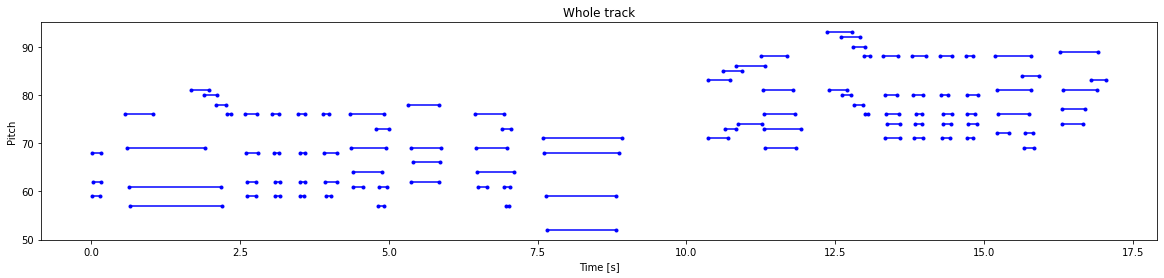

In [13]:
training_df_raw_sample_notes = training_df_raw.iloc[20000:20100].copy()
training_df_raw_sample_notes['velocity'] = 77
training_df_raw_sample_midi = notes_to_midi(training_df_raw_sample_notes, 0, False)
training_df_raw_sample_notes_raw = (
    notes_windowed_to_notes_raw(training_df_raw_sample_notes[['pitch', 'step', 'duration', 'velocity']])
)
plot_piano_roll(training_df_raw_sample_notes_raw)
display_audio(training_df_raw_sample_midi)

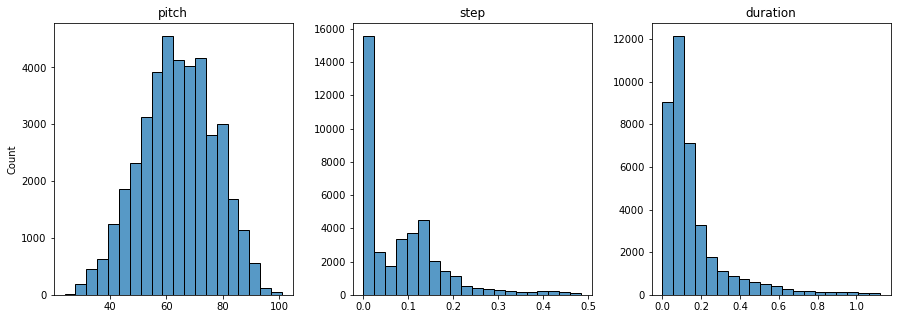

In [14]:
plot_distributions(training_df_raw)

In [15]:
def process_df(df_raw, scaler):
    
    df = df_raw.copy()
        
    df['pitch'] = (df['pitch'] - 21)  
    df['pitch_digitized'] = df['pitch']
    #df['pitch'] = df['pitch'] / 88
    
    # Scale variables to N(0, 1)
    scaled_values = scaler.transform(df[['pitch', 'step', 'duration']].to_numpy())
    df[['pitch', 'step', 'duration']] = pd.DataFrame(scaled_values, index=df.index, columns=['pitch', 'step', 'duration'])
    
    return df

normalizer = StandardScaler().fit(training_df_raw[['pitch', 'step', 'duration']].to_numpy())
training_df = process_df(training_df_raw, normalizer)
validation_df = process_df(validation_df_raw, normalizer)
    
#step_duration_scaler = MinMaxScaler().fit(training_df_raw[['step', 'duration']])
#training_df = process_df(training_df_raw, step_duration_scaler)
#validation_df = process_df(validation_df_raw, step_duration_scaler)
#testing_df = process_df(testing_df_raw, step_duration_scaler)

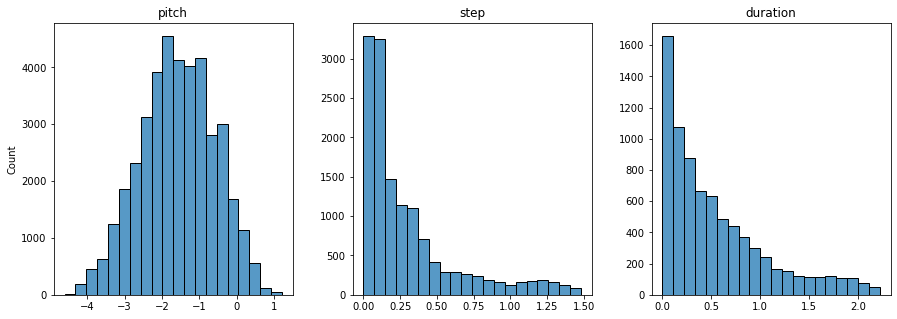

In [16]:
plot_distributions(training_df)

In [17]:
total_num_notes = training_df.shape[0] + validation_df.shape[0]# + testing_df.shape[0]

training_percent_of_total = round(training_df.shape[0] / total_num_notes * 100, 2)
validation_percent_of_total = round(validation_df.shape[0] / total_num_notes * 100, 2)
#testing_percent_of_total = round(testing_df.shape[0] / total_num_notes * 100, 2)

print(f'training dataframe shape: {training_df.shape} --- percent of total notes: {training_percent_of_total}')
print(f'validation dataframe shape: {validation_df.shape} --- percent of total notes: {validation_percent_of_total}')
#print(f'testing dataframe shape: {testing_df.shape} --- percent of total notes: {testing_percent_of_total}')

training_df.head()

training dataframe shape: (39984, 5) --- percent of total notes: 85.77
validation dataframe shape: (6636, 5) --- percent of total notes: 14.23


,pitch,step,duration,song_beginning,pitch_digitized
0,-0.452378,-0.434671,0.251406,1,58
1,-1.359718,-0.357421,0.213160,1,46
2,-0.452378,2.057920,0.168540,1,58
3,-1.359718,-0.347121,0.095235,1,46
4,-0.452378,1.769521,0.222722,1,58


In [18]:
class DatasetGenerator:
    
    def __init__(self, _data, sequence_length, batch_size, return_target, 
                 pitch_bounds=PITCH_BOUNDS, x_keys=KEYS, seed=None):
        
        assert isinstance(_data, pd.core.frame.DataFrame), 'pass in dataframe'
    
        self.X = _data[['pitch', 'step', 'duration']].copy().to_numpy()
        self.Y = _data[['pitch_digitized', 'step', 'duration']].copy().to_numpy()
        song_beginning = _data['song_beginning']
        
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.return_target = return_target
                
        self.seed = seed
        
        # Subset data to usable notes
        def get_if_t_is_usable(t):

            c1 = t < len(song_beginning) - self.sequence_length - 1
            c2 = song_beginning[t] == 0
            return c1 and c2 and song_beginning[t + self.sequence_length - 1] == 0

        self.data_indices = np.array([ t for t in range(len(song_beginning)) if get_if_t_is_usable(t) ])
        self.n = len(self.data_indices)
        
        self.total_observations_per_epoch = self.n - (self.n % self.batch_size)
        self.num_batches_per_epoch =  self.total_observations_per_epoch // self.batch_size
        
        self.batch_beg_id = 0
        self.batch_end_id = self.batch_size
        
    def __iter__(self):
        
        if self.seed is not None:
            np.random.seed(self.seed)
            
        while True:
            
            if self.batch_beg_id == 0:                
                np.random.shuffle(self.data_indices)
               
            # This batch's inputs' beginning row numbers in self.data
            x_starts = self.data_indices[self.batch_beg_id : self.batch_end_id]
            
            # This batch's labels' row numbers in self.data
            x_ends = x_starts + self.sequence_length
                        
            batch_x = np.stack([ self.X[x_start:x_end] for x_start, x_end in zip(x_starts, x_ends) ])
            
            if self.return_target:
                batch_y = {}
                batch_y['pitch'] = self.Y[x_ends, 0]
                batch_y['step'] = self.Y[x_ends, 1]
                batch_y['duration'] = self.Y[x_ends, 2]
            
            self.batch_beg_id += self.batch_size
            self.batch_end_id += self.batch_size
            
            if self.batch_end_id >= self.total_observations_per_epoch:
                self.batch_beg_id = 0
                self.batch_end_id = self.batch_size
            
            if self.return_target:
                yield tf.constant(batch_x), {k: tf.constant(v) for k, v in batch_y.items()}
            else:
                yield tf.constant(batch_x)
            
            
    def __call__(self):
        return self.__iter__()
    

In [20]:
class SamplerGenerator:
    
    def __init__(self, generators, sample_size=1000, seed=None):
        
        self.generators = [iter(gen) for gen in generators]
        self.num_generators = len(self.generators)
        
        self.sample_size = sample_size
        self.seed = seed
        
    def __iter__(self):
        
        if self.seed is not None:
            np.random.seed(seed)
        
        while True:
            
            g_idx = np.random.randint(0, self.num_generators, size=self.sample_size) 
            
            for g in g_idx:
                yield next(self.generators[g])
                
    def __call__(self):
        return self.__iter__()
    

In [188]:
rnn_base_generator_args = {'sequence_length': SEQUENCE_LENGTH, 'batch_size': BATCH_SIZE, 'return_target': True}

rnn_generator_output_signature = (
    tf.TensorSpec(shape=(BATCH_SIZE, SEQUENCE_LENGTH, 3), dtype=tf.float32, name=None),
   {'pitch': tf.TensorSpec(shape=(BATCH_SIZE,), dtype=tf.float32, name=None),
    'step': tf.TensorSpec(shape=(BATCH_SIZE,), dtype=tf.float32, name=None),
    'duration': tf.TensorSpec(shape=(BATCH_SIZE,), dtype=tf.float32, name=None),
   })

RNN_NUM_TRAINING_SUBSETS = 10
RNN_NUM_VALIDATION_SUBSETS = 3

num_input_cols = 3
    
rnn_training_sub_generators = [DatasetGenerator(training_df, seed=19*i, **rnn_base_generator_args) 
                               for i in range(RNN_NUM_TRAINING_SUBSETS)]    

rnn_training_sampler_generator = SamplerGenerator(rnn_training_sub_generators)

rnn_train_cardinality = rnn_training_sub_generators[0].n // BATCH_SIZE - 1

rnn_train_dataset = (tf.data.Dataset
                     .from_generator(rnn_training_sampler_generator, output_signature=rnn_generator_output_signature)
                     .cache()
                     .prefetch(tf.data.AUTOTUNE)
                     .apply(tf.data.experimental.assert_cardinality(rnn_train_cardinality))
                    )

rnn_validation_sub_generators = [DatasetGenerator(validation_df, seed=21*i, **rnn_base_generator_args) 
                                 for i in range(RNN_NUM_VALIDATION_SUBSETS)]  

rnn_validation_sampler_generator = SamplerGenerator(rnn_validation_sub_generators)

rnn_valid_cardinality = rnn_validation_sub_generators[0].n // BATCH_SIZE - 1

rnn_valid_dataset = (tf.data.Dataset
                     .from_generator(rnn_validation_sampler_generator, output_signature=rnn_generator_output_signature)
                     .cache()
                     .prefetch(tf.data.AUTOTUNE)
                     .apply(tf.data.experimental.assert_cardinality(rnn_valid_cardinality))
                    )

In [189]:
%%time
x = None
for _ in rnn_train_dataset.take(500):
    x = _
    
print('Sample batch input data (first 10 rows of first element in batch)\n', x[0][0, :10, :], '\n')
print('Sample batch output data')
for _ in x[1].items():
    print(_)

Sample batch input data (first 10 rows of first element in batch)
 tf.Tensor(
[[-0.7548246  -0.39506987  0.11652386]
 [-0.60360134  0.31677336 -0.29954717]
 [-0.83043617 -0.39506987 -0.37297148]
 [-1.7377756  -0.39506987 -0.421921  ]
 [-0.60360134  0.4354139   0.312322  ]
 [-3.1743963  -0.39506987 -0.421921  ]
 [-0.83043617 -0.39506987  0.26337245]
 [-1.662164    0.47496074 -0.39744624]
 [-2.267057   -0.39506987 -0.421921  ]
 [-1.8889989  -0.39506987 -0.421921  ]], shape=(10, 3), dtype=float32) 

Sample batch output data
('pitch', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([54., 38., 57., 27., 36., 22., 39., 57., 52., 44., 43., 54., 57.,
       60., 59., 34., 45., 28., 39., 45., 53., 32., 14., 34., 51., 44.,
       44., 19., 48., 33., 14., 67.], dtype=float32)>)
('step', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.43461668, -0.39506987,  5.49741   , -0.43461668, -0.39506987,
       -0.35552302, -0.03914825,  0.07949229,  0.5936013 ,  0.5936013 ,
       -0.4346166

In [190]:
def mse_with_positive_pressure(y_true, y_pred, pressure_threshold=0, pressure_factor=10):
    mse = (y_true - y_pred) ** 2
    positive_pressure = pressure_factor * tf.maximum(pressure_threshold-y_pred, 0)
    return tf.reduce_mean(mse + positive_pressure)

In [191]:
input_shape = (SEQUENCE_LENGTH, 3)

inputs = tf.keras.Input(input_shape, name='input')
x = LSTM(128, activation='sigmoid', return_sequences=True,
         #dropout=.3, recurrent_dropout=.3, 
         #kernel_regularizer=L2(), recurrent_regularizer=L2(),
         name='lstm_1'
        )(inputs)
#x = tf.keras.layers.LSTM(128, activations='sigmoid', return_sequences=True,
#                         dropout=.3, recurrent_dropout=.1,
#                         #kernel_regularizer=tf.keras.regularizers.L2(), recurrent_regularizer=tf.keras.regularizers.L2(),
#                        name='lstm_2')(x)
x = LSTM(128, activation='sigmoid', 
         #dropout=.3, recurrent_dropout=.3, 
         kernel_regularizer=L2(1e-2), recurrent_regularizer=L2(1e-2),
         name='lstm_3')(x)

x = Dense(64, activation='sigmoid')(x)
x = Dropout(.3)(x)

outputs = {'pitch': tf.keras.layers.Dense(88, activation='linear', name='pitch')(x), 
           'step': tf.keras.layers.Dense(1, activation='linear', name='step')(x),
           'duration': tf.keras.layers.Dense(1, activation='linear', name='duration')(x),
           #'velocity': tf.keras.layers.Dense(1, activation='linear', name='velocity')(x)
          }

# Define duration loss
duration_mse_with_pressure = mse_with_positive_pressure
duration_mse_with_pressure.pressure_threshold = 0.01

loss = {'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': duration_mse_with_pressure,
        #'velocity': 'mse'
       }

model = tf.keras.Model(inputs, outputs, name='rnn')
total_trained_epochs = 0
model_num_params = model.count_params()
velocity_indicator_str = 'Yvel_' if 'model' in KEYS else 'Nvel_'

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_weights = {'pitch': .05, 'step': 1, 'duration': 1}

model.compile(loss=loss, 
              loss_weights=loss_weights, 
              optimizer=optimizer)

In [192]:
def load_rnn_model(model_path):
    return tf.keras.models.load_model(model_path, 
                                      custom_objects = {'mse_with_positive_pressure': mse_with_positive_pressure})

model_names = ['15_files_359386_params_Nvel_005_epochs_0.544_loss',
               '15_files_227802_params_Nvel010_epochs_0.554_loss',
               '20_files_227802_params_Nvel_005_epochs_0.573_loss'
              ]

model_to_load = model_names[-1]

load_model_flag = False

if load_model_flag and os.path.exists(MODEL_DIR + model_to_load):
    
    print(f'loading model {model_to_load}')
    model = load_rnn_model(MODEL_DIR + model_to_load)
    model_name = model_to_load
    
    num_training_files = int(re.sub('_|files', '', re.search('\d+_files', model_name).group(0)))
    velocity_indicator_str = re.search('[NY]vel', model_name).group(0)
    total_trained_epochs = int(re.sub('_|epochs', '', re.search('\d+_epochs', model_name).group(0)))
    last_loss = float(re.search('\d+\.\d+', model_name).group(0))
    
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 25, 128)      67584       ['input[0][0]']                  
                                                                                                  
 lstm_3 (LSTM)                  (None, 128)          131584      ['lstm_1[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['lstm_3[0][0]']                 
                                                                                                

In [193]:
num_training_files_str = f'{training_df.shape[0]}_files_'

rnn_early_stop_ckpt_clbk = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=4, restore_best_weights=False, verbose=0
)

rnn_reduce_lr_clbk = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=.1)

rnn_callbacks = [rnn_reduce_lr_clbk, rnn_early_stop_ckpt_clbk]

In [194]:
%%time

epochs = 1

absl.logging.set_verbosity(absl.logging.ERROR)

history = model.fit(rnn_train_dataset, epochs=epochs, steps_per_epoch=100, 
                    #validation_data=rnn_valid_dataset, validation_steps=VALIDATION_STEPS_PER_EPOCH,
                    callbacks=rnn_callbacks
                   ).history

total_trained_epochs += epochs
last_loss = round(history['loss'][-1], 3)

num_training_files_str = f'{num_training_files}_files_'
num_params_str = f'{model.count_params()}_params_'
epochs_str = f'{total_trained_epochs:03d}_epochs_'
loss_str = f'{last_loss}_loss'
model_name = num_training_files_str + num_params_str + velocity_indicator_str + epochs_str + loss_str

model_save_path = MODEL_DIR + model_name
#model.save(model_save_path)

100/100 [==============================] - 6s 41ms/step - loss: 3.6467 - duration_loss: 1.2243 - pitch_loss: 4.2848 - step_loss: 0.7906 - lr: 0.0010
Wall time: 5.73 s


## Generate notes from RNN

In [222]:
def rnn_predict_next_note(notes, keras_model,
                          temperature=1.0, velocity=CONSTANT_VELOCITY):

    assert temperature > 0
    assert len(notes.shape) == 2
        
    def process_logits(logits):
        logits /= temperature
        var = tf.random.categorical(logits, num_samples=1)
        var = tf.squeeze(var, axis=-1)
        return var

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)    
    predictions = keras_model.predict(inputs)
    
    note_dict = {}
    
    note_dict['pitch'] = process_logits(predictions['pitch'])[0].numpy().round()
    note_dict['step'] = tf.squeeze(predictions['step']).numpy()
    note_dict['duration'] = tf.squeeze(predictions['duration']).numpy()
    
    if 'velocity_digitized' in predictions.keys():
        note_dict['velocity_digitized'] = process_logits(predictions['velocity_digitized'])[0].numpy()
    else:
        note_dict['velocity'] = velocity
        
    return note_dict


def generate_song(model, midi_paths, num_predictions, note_prediction_function, 
                  scaler=normalizer, keys=KEYS,
                  sequence_length=SEQUENCE_LENGTH, pitch_bounds=PITCH_BOUNDS, random_seed=None, temperature=1, 
                  velocity=CONSTANT_VELOCITY, temp_path=TEMP_OUTPUT_PATH):
    
    if random_seed is not None:
        np.random.seed(random_seed)
        
    path = np.random.choice(midi_paths)
    pm = pretty_midi.PrettyMIDI(path)
    
    df = create_note_dataframe(np.array([path]), keys, sequence_length, .01, num_files_total=1)
    
    x = df[['pitch', 'step', 'duration']].to_numpy()[:sequence_length]
    x = scaler.transform(x)
    
    X = np.zeros(shape=(sequence_length + num_predictions, 3))
    X[:sequence_length] = x
        
    song_dict = {'start': [], 'end': [], 'pitch': [], 'velocity': []}
        
    prev_start = 0
    for y_id in range(num_predictions):
        
        x = X[y_id:y_id + sequence_length]
        y_dict = note_prediction_function(x, model, temperature=temperature, velocity=velocity)
        
        pitch, step, duration, velocity = y_dict['pitch'], y_dict['step'], y_dict['duration'], y_dict['velocity']
        
        y = np.array([pitch, step, duration]).reshape(1, -1)
        y_note_data = scaler.inverse_transform(y)[0]
                
        X[y_id + sequence_length] = y
        
        pitch_data = np.clip(round(y_note_data[0]), 21, 108)
        step_data = max(y_note_data[1], 0)
        duration_data = max(y_note_data[2], .01)
        
        start = prev_start + step_data
        end = start + duration_data
        
        song_dict['start'].append(start)
        song_dict['end'].append(end)
        song_dict['pitch'].append(pitch)
        song_dict['velocity'].append(velocity)
        
        prev_start = start
        
    generated_notes = pd.DataFrame(song_dict)
    return generated_notes
    
    
def generate_and_save_songs(save, model, midi_paths, output_dir, num_songs, notes_per_song, note_prediction_function,
                            seed=None, temperature=1.0, sequence_length=SEQUENCE_LENGTH, 
                            constant_velocity=CONSTANT_VELOCITY, instrument=0,
                            pitch_bounds=PITCH_BOUNDS
                           ):
    
    if output_dir[-1] != '/':
        output_dir += '/'
    
    if save and not os.path.exists(output_dir):
        os.mkdir(output_dir)
        
    if isinstance(temperature, float):
        temperature = [temperature] * num_songs
        
    assert len(temperature) == num_songs, 'len temperature != num_songs'
    
    generated_song_dfs = []
    generated_midis = []
    for song_id, temp in zip(range(num_songs), temperature):
        
        song_df = generate_song(model, midi_paths, notes_per_song, note_prediction_function,
                                sequence_length=sequence_length, random_seed=seed, temperature=temp,
                                pitch_bounds=PITCH_BOUNDS, velocity=CONSTANT_VELOCITY, 
                               )
                
        generated_song_dfs.append(song_df)
        
        midi_output_path = output_dir + f'sample_{song_id+1}_{notes_per_song}_notes_{round(temp, 2)}_temp.mid'
        midi = notes_to_midi(song_df, instrument, save, midi_output_path, constant_velocity=CONSTANT_VELOCITY) 
            
        generated_midis.append(midi)
        
        print(f'finished song # {song_id+1}')
        
        if save:
            print(f'wrote song # {song_id+1} to:\n{midi_output_path}\n')
        
    return generated_song_dfs, generated_midis
    

In [226]:
sample_generated_song = generate_song(
    model, MAESTRO_TRAIN_MIDI_PATHS, 100, rnn_predict_next_note, random_seed=6, temperature=.1
)
sample_generated_midi = notes_to_midi(sample_generated_song, 0, False)

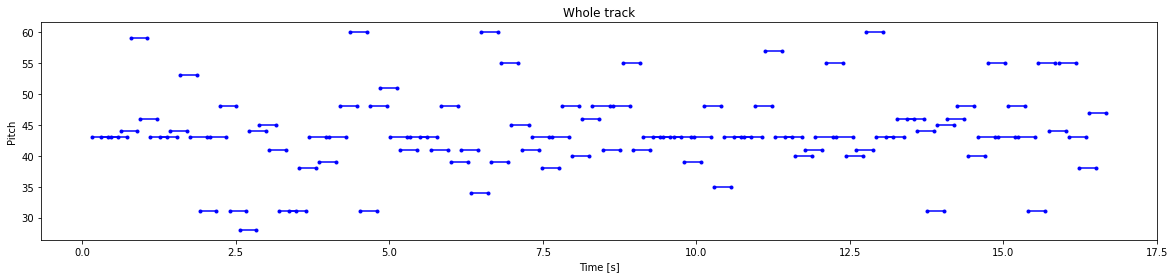

In [227]:
plot_piano_roll(sample_generated_song)

In [228]:
display_audio(sample_generated_midi)

In [78]:
generation_midi_seed_paths = MAESTRO_TRAIN_MIDI_PATHS
midi_output_dir = OUTPUT_DIR + model_name
num_songs_to_generate = 4
num_notes_per_generated_song = 100
generation_seed = 11
generation_temperature = [1.0, 2.0, 5.0, 25]

generated_notes, generated_midis = generate_and_save_songs(
    True, model, generation_midi_seed_paths, midi_output_dir, num_songs_to_generate, num_notes_per_generated_song,
    rnn_predict_next_note, generation_seed, generation_temperature
)

finished song # 1
wrote song # 1 to:
C:/_local/py/maestro_rnn/outputs/5_files_158298_params_Nvel_030_epochs_0.238_loss/sample_1_100_notes_1.0_temp.mid

finished song # 2
wrote song # 2 to:
C:/_local/py/maestro_rnn/outputs/5_files_158298_params_Nvel_030_epochs_0.238_loss/sample_2_100_notes_2.0_temp.mid

finished song # 3
wrote song # 3 to:
C:/_local/py/maestro_rnn/outputs/5_files_158298_params_Nvel_030_epochs_0.238_loss/sample_3_100_notes_5.0_temp.mid

finished song # 4
wrote song # 4 to:
C:/_local/py/maestro_rnn/outputs/5_files_158298_params_Nvel_030_epochs_0.238_loss/sample_4_100_notes_25_temp.mid



## Single-Sequence Variational Autoencoder

This variational autoencoder is trained on 32-sequences of notes. Then an RNN is used (with the autoencoder parameters frozen) to attempt to predict the next latent vector given a latent vector from this autoencoder.

In [54]:
class NoteSequenceGenerator():
    
    def __init__(self, _data, sequence_length, batch_size, seed=None):
        
        assert isinstance(_data, pd.core.frame.DataFrame), 'pass in dataframe'
    
        self.X = _data[['pitch', 'step', 'duration']].copy().to_numpy()
        self.Y = _data[['pitch_digitized', 'step', 'duration']].copy().to_numpy()
        song_beginning = _data['song_beginning']
        
        self.sequence_length = sequence_length
        self.batch_size = batch_size                
        self.seed = seed
        
        # Subset data to usable notes
        def get_if_t_is_usable(t):

            c1 = t < len(song_beginning) - self.sequence_length - 1
            c2 = song_beginning[t] == 0
            return c1 and c2 and song_beginning[t + self.sequence_length - 1] == 0

        self.data_indices = np.array([ t for t in range(len(song_beginning)) if get_if_t_is_usable(t) ])
        self.n = len(self.data_indices)
        
        self.total_observations_per_epoch = self.n - (self.n % self.batch_size)
        self.num_batches_per_epoch =  self.total_observations_per_epoch // self.batch_size
        
        self.batch_beg_id = 0
        self.batch_end_id = self.batch_size
        
    def __iter__(self):
        
        if self.seed is not None:
            np.random.seed(self.seed)
            
        while True:
            
            if self.batch_beg_id == 0:                
                np.random.shuffle(self.data_indices)
               
            # This batch's inputs' beginning row numbers in self.data
            x_starts = self.data_indices[self.batch_beg_id : self.batch_end_id]
            
            # This batch's labels' row numbers in self.data
            x_ends = x_starts + self.sequence_length
                        
            batch_x = np.stack([ self.X[x_start:x_end] for x_start, x_end in zip(x_starts, x_ends) ])
            batch_y = np.stack([ self.Y[x_start:x_end] for x_start, x_end in zip(x_starts, x_ends) ])
            
            self.batch_beg_id += self.batch_size
            self.batch_end_id += self.batch_size
            
            if self.batch_end_id >= self.total_observations_per_epoch:
                self.batch_beg_id = 0
                self.batch_end_id = self.batch_size
                
            yield tf.constant(batch_x), tf.constant(batch_y)
            
            
    def __call__(self):
        return self.__iter__()    

In [49]:
VAE_NUM_TRAINING_SUBSETS = 10
VAE_NUM_VALIDATION_SUBSETS = 4
VAE_SEQUENCE_LENGTH = 32

vae_generator_output_signature = (
    tf.TensorSpec(shape=(BATCH_SIZE, VAE_SEQUENCE_LENGTH, 3)),
    tf.TensorSpec(shape=(BATCH_SIZE, VAE_SEQUENCE_LENGTH, 3))
)
    
    
vae_base_generator_args = {'sequence_length': VAE_SEQUENCE_LENGTH, 'batch_size': BATCH_SIZE}

vae_training_sub_generators = [NoteSequenceGenerator(training_df, seed=9*i, **vae_base_generator_args) 
                               for i in range(VAE_NUM_TRAINING_SUBSETS)]    
vae_training_sampler_generator = SamplerGenerator(vae_training_sub_generators)

vae_train_ds_cardinality = vae_training_sub_generators[0].n // BATCH_SIZE

vae_train_ds = (tf.data.Dataset
                .from_generator(vae_training_sampler_generator, output_signature=vae_generator_output_signature)
                .cache()
                .prefetch(tf.data.AUTOTUNE)
                .apply(tf.data.experimental.assert_cardinality(vae_train_ds_cardinality))
               )

vae_validation_sub_generators = [NoteSequenceGenerator(validation_df, seed=8*i, **vae_base_generator_args) 
                                 for i in range(VAE_NUM_VALIDATION_SUBSETS)]    
vae_validation_sampler_generator = SamplerGenerator(vae_validation_sub_generators)

vae_valid_ds_cardinality = vae_validation_sub_generators[0].n // BATCH_SIZE - 1

vae_valid_ds = (tf.data.Dataset
                .from_generator(vae_validation_sampler_generator, output_signature=vae_generator_output_signature)
                .cache()
                .prefetch(tf.data.AUTOTUNE)
                .apply(tf.data.experimental.assert_cardinality(vae_valid_ds_cardinality))
               )

In [50]:
%%time
x = None
y = None
num_to_take = 500
for _ in vae_train_ds.take(num_to_take):
    x, y = _
    
print('Sample batch x data (first 10 rows of first element in batch_x)\n', x[0, :10, :].numpy(), '\n')
print('Sample batch y data (first 10 rows of first element in batch_y)\n', y[0, :10, :].numpy(), '\n')

Sample batch x data (first 10 rows of first element in batch_x)
 [[-2.2670569e+00  4.9427520e-02 -1.3742688e-01]
 [-2.7963383e+00  2.2967681e-01 -1.7248559e-01]
 [-2.6451149e+00  1.4212716e-01 -1.5336266e-01]
 [-1.1328827e+00 -2.0722796e-03  3.0558777e-01]
 [-1.3597175e+00 -4.0377071e-01  2.0678593e-01]
 [-2.4938917e+00 -2.5957128e-01 -2.6491311e-01]
 [-2.4182801e+00  3.3977579e-02 -2.7447456e-01]
 [-2.6451149e+00  1.5757710e-01 -2.2666724e-01]
 [-2.4938917e+00  6.4877458e-02 -3.2546908e-01]
 [-1.2084943e+00  5.4577500e-02  1.5549527e+00]] 

Sample batch y data (first 10 rows of first element in batch_y)
 [[ 3.4000000e+01  4.9427520e-02 -1.3742688e-01]
 [ 2.7000000e+01  2.2967681e-01 -1.7248559e-01]
 [ 2.9000000e+01  1.4212716e-01 -1.5336266e-01]
 [ 4.9000000e+01 -2.0722796e-03  3.0558777e-01]
 [ 4.6000000e+01 -4.0377071e-01  2.0678593e-01]
 [ 3.1000000e+01 -2.5957128e-01 -2.6491311e-01]
 [ 3.2000000e+01  3.3977579e-02 -2.7447456e-01]
 [ 2.9000000e+01  1.5757710e-01 -2.2666724e-01]
 [ 

In [57]:
class VAE(tf.keras.Model):
    
    def __init__(self, training_data_spec, latent_dim, scaler=None):
        super(VAE, self).__init__()
        
        self.batch_size, self.sequence_length, self.p = training_data_spec[0].shape
        self.k = latent_dim
        self.num_keys = 90
        self.scaler = scaler
        
        observation_shape = (self.sequence_length, self.p)
        
        encoder_input = Input(shape=observation_shape, name='encoder_input')
        
        encoder_hidden_1 = Bidirectional(
            LSTM(128, activation='tanh', 
                 return_sequences=True, 
                 dropout=.3, recurrent_dropout=.3,),
            name='encoder_lstm_1'
        )(encoder_input)
        
        encoder_hidden_2 = LSTM(
            128, activation='tanh', 
            dropout=.3, recurrent_dropout=.3, 
            name='encoder_hidden_2')(encoder_hidden_1)
                
        encoder_mu = tf.keras.layers.Dense(self.k, activation='linear', name='encoder_mu')(encoder_hidden_2)
        encoder_log_sigma = tf.keras.layers.Dense(self.k, activation='linear', name='encoder_log_sigma')(encoder_hidden_2)
        
        decoder_input = tf.keras.layers.Input(shape=(self.k), name='decoder_input')
        
        decoder_hidden_1 = tf.keras.layers.Dense(256, activation='tanh', name='decoder_hidden_1')(decoder_input)
        #decoder_hidden_2 = tf.keras.layers.Dense(256, activation='tanh', name='decoder_hidden_2')(decoder_hidden_1)
                
        decoder_reconstruction = tf.keras.layers.Dense(
            self.sequence_length * self.num_keys, activation='linear', name='decoder_reconstruction'
        )(decoder_hidden_1)
        
        decoder_output = tf.keras.layers.Reshape(
            target_shape=(self.sequence_length, self.num_keys), name='decoder_output'
        )(decoder_reconstruction)
        
        self.encoder = tf.keras.Model(encoder_input, [encoder_mu, encoder_log_sigma], name='encoder')
        self.decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
        
        #self.log_sig_x = tf.Variable(initial_value=np.ones(shape=observation_shape), dtype=tf.float32, trainable=True)
        #self.binary_crossentropy = tf.keras.losses.Binary_Crossentropy(
        #    from_logits=False, reduction=reduction=losses_utils.ReductionV2.NONE
        #)
        
        self.sparse_crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )            
        
    def compile(self, optimizer, loss_weight=1):
        super(VAE, self).compile()
                
        self.optimizer = optimizer 
        self.loss_weight = loss_weight
        
        self.encoder.compile(self.optimizer, loss=None)
        self.decoder.compile(self.optimizer, loss=None)
        
    def sample_and_reparameterize(self, mu_log_sigma, n_samples=1):

        mu, log_sigma = mu_log_sigma
        sigma = tf.exp(log_sigma)

        b, k = mu.shape

        if n_samples == 1:      
            eps = tf.random.normal(shape=(b, k))
            return eps * sigma + mu
        else:
            eps = tf.random.normal(shape=(b, k))
            return [eps * sigma + mu for n in range(n_samples)]  
        
    def reconstruction_loss(self, x, x_hat):
        
        pitch_loss = self.sparse_crossentropy(x[:, :, 0], x_hat[:, :, :88])
        pitch_loss = tf.reduce_mean( pitch_loss, axis=[0, 1]) # <-- mean cross-entropy for batch
        
        step_loss = (x[:, :, 1] - x_hat[:, :, 88]) ** 2
        step_loss = tf.reduce_mean( step_loss, axis=[0, 1] )
        
        duration_loss = (x[:, :, 1] - x_hat[:, :, 89]) ** 2
        duration_loss = tf.reduce_mean( duration_loss, axis=[0, 1] )
        
        return pitch_loss + step_loss + duration_loss
            
    def kl_divergence(self, mu_z, log_sigma_z):

        kl = tf.exp(log_sigma_z) + tf.square(mu_z) - 1 - log_sigma_z
        return tf.reduce_mean(.5 * tf.reduce_sum(kl, axis=1), axis=0)
            
    def vae_loss(self, x1_x2):

        mu_z, log_sigma_z = self.encoder(x1_x2[0])
        z = self.sample_and_reparameterize([mu_z, log_sigma_z])
        x_hat = self.decoder(z)

        reconstruction_loss = self.reconstruction_loss(x1_x2[1], x_hat)
        kl_divergence = self.kl_divergence(mu_z, log_sigma_z)

        return reconstruction_loss + kl_divergence
                
    def compute_loss(self, x1_x2):
        return self.vae_loss(x1_x2)        

    def train_step(self, x1_x2):
        
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x1_x2)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}
    
    def test_step(self, x1_x2):
        
        loss = self.compute_loss(x1_x2)
        return {'loss': loss}
    
    def call(self, inputs, is_training=False):
        
        inputs_is_list = isinstance(inputs, list)
        
        if inputs_is_list and is_training:
            return [self.train_step(x1_x2) for x1_x2 in inputs]
        
        elif inputs_is_list and not is_training:
            return [self.test_step(x1_x2) for x1_x2 in inputs]
        
        elif not inputs_is_list and is_training:
            return self.train_step(inputs)
        
        elif not inputs_is_list and not is_training:
            return self.test_step(inputs)
        
    def save(self, folder_path):
        
        self.encoder.save(folder_path + 'encoder')
        self.decoder.save(folder_path + 'decoder')
        
    def load(self, folder_path):
        
        paths = [folder_path + f for f in os.listdir(folder_path)]
        
        encoder_path = None
        decoder_path = None
        log_sig_x_path = None
        
        for p in paths:
            
            if 'encoder' in p:
                encoder_path = p
            if 'decoder' in p:
                decoder_path = p
                
        self.encoder = tf.keras.models.load_model(encoder_path)
        self.decoder = tf.keras.models.load_model(decoder_path)
        
    def count_params(self):
        return self.encoder.count_params() + self.decoder.count_params()
        
    def reconstruct_songs(self, songs, temperature=1, argmax=False):
        
        mu_z, log_sigma_z = self.encoder(songs)
        z = self.sample_and_reparameterize([mu_z, log_sigma_z])
        x_hat = self.decoder(z).numpy()
                
        pitch_logits = x_hat[:, :, :88]
        pitches = self.sample_pitches_from_batch(pitch_logits, temperature, argmax)    
        
        step = x_hat[:, :, 88:89]
        duration = x_hat[:, :, 89:90]

        songs = np.concatenate([pitches, step, duration], axis=-1)
        
        if self.scaler is not None:
            for s in range(songs.shape[0]):            
                scaled_values = self.scaler.inverse_transform(songs[s])
                songs[s, :, 1] = scaled_values[:, 1]
                songs[s, :, 2] = scaled_values[:, 2]
                
        songs[:, :, 1] = np.maximum(songs[:, :, 1], 0)
        songs[:, :, 2] = np.maximum(songs[:, :, 2], .01)
        
        return songs
    
    def sample_pitches_from_batch(self, logits, temperature=1, argmax=False):

        # logits.shape = [batch_size, sequence_length, num_output_keys]
        # output.shape = [batch_size, sequence_length, 1]
        
        logits /= temperature
        
        if argmax:
            pitches = np.apply_along_axis(np.argmax, 2, logits)
            pitches = np.expand_dims(pitches, -1)
            return pitches + 21
        
        else:
            song_pitches = [tf.random.categorical(logits[b], num_samples=1).numpy() for b in range(logits.shape[0])]
            pitches = np.stack(song_pitches, axis=0)
            return pitches + 21
            
    def generate_songs(self, temperature=1, argmax=False):
                
        z = tf.random.normal(shape=(self.batch_size, self.k))
        x = self.decoder(z).numpy()

        pitch_logits = x[:, :, :88]
        pitches = self.sample_pitches_from_batch(pitch_logits, temperature, argmax)

        step = x[:, :, 88:89]
        duration = x[:, :, 89:90]
        
        songs = np.concatenate([pitches, step, duration], axis=-1)
        
        if self.scaler is not None:
            for s in range(songs.shape[0]):            
                scaled_values = self.scaler.inverse_transform(songs[s])
                songs[s, :, 1] = scaled_values[:, 1]
                songs[s, :, 2] = scaled_values[:, 2]
                
        songs[:, :, 1] = np.maximum(songs[:, :, 1], 0)
        songs[:, :, 2] = np.maximum(songs[:, :, 2], .01)
        
        return songs

vae = VAE(vae_train_ds.element_spec, 32, normalizer)

vae_total_trained_epochs = 0
vae.compile(tf.keras.optimizers.Adam())

vae.encoder.summary()
vae.decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 3)]      0           []                               
                                                                                                  
 encoder_lstm_1 (Bidirectional)  (None, 32, 256)     135168      ['encoder_input[0][0]']          
                                                                                                  
 encoder_hidden_2 (LSTM)        (None, 128)          197120      ['encoder_lstm_1[0][0]']         
                                                                                                  
 encoder_mu (Dense)             (None, 32)           4128        ['encoder_hidden_2[0][0]']       
                                                                                            

In [61]:
%%time

vae_early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vae_reduce_lr_clbk = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=.1)
vae_clbk_list = [vae_early_stop_clbk, vae_reduce_lr_clbk]

epochs = 7

absl.logging.set_verbosity(absl.logging.ERROR)

vae_history = vae.fit(vae_train_ds, epochs=epochs, #steps_per_epoch=400,
                      #validation_data=vae_valid_ds, validation_steps=650,
                      callbacks=vae_clbk_list
                     ).history

vae_total_trained_epochs += len(vae_history['loss'])
vae_last_loss = round(vae_history['loss'][-1], 3)

vae_num_training_files_str = f'{num_training_files}_files_'
vae_num_params_str = f'{vae.count_params()}_params_'
vae_epochs_str = f'{vae_total_trained_epochs:03d}_epochs_'
vae_loss_str = f'{vae_last_loss}_loss/'
vae_model_name = vae_num_training_files_str + vae_num_params_str + vae_epochs_str + vae_loss_str

vae_model_save_path = MODEL_DIR + vae_model_name
vae.save(vae_model_save_path)

Epoch 1/7
1241/1241 [==============================] - 153s 123ms/step - loss: 5.9411 - lr: 0.0010
Epoch 2/7
1241/1241 [==============================] - 165s 133ms/step - loss: 5.9169 - lr: 0.0010
Epoch 3/7
1241/1241 [==============================] - 165s 133ms/step - loss: 5.9469 - lr: 0.0010
Epoch 4/7
1241/1241 [==============================] - 171s 138ms/step - loss: 6.0506 - lr: 1.0000e-04
Epoch 5/7
1241/1241 [==============================] - 168s 135ms/step - loss: 5.9616 - lr: 1.0000e-04
Epoch 6/7
1241/1241 [==============================] - 175s 141ms/step - loss: 6.0525 - lr: 1.0000e-05
INFO:tensorflow:Assets written to: C:/_local/py/maestro_rnn/models/5_files_1089152_params_009_epochs_9.749_loss/encoder\assets


INFO:tensorflow:Assets written to: C:/_local/py/maestro_rnn/models/5_files_1089152_params_009_epochs_9.749_loss/encoder\assets


INFO:tensorflow:Assets written to: C:/_local/py/maestro_rnn/models/5_files_1089152_params_009_epochs_9.749_loss/decoder\assets


INFO:tensorflow:Assets written to: C:/_local/py/maestro_rnn/models/5_files_1089152_params_009_epochs_9.749_loss/decoder\assets


Wall time: 16min 43s


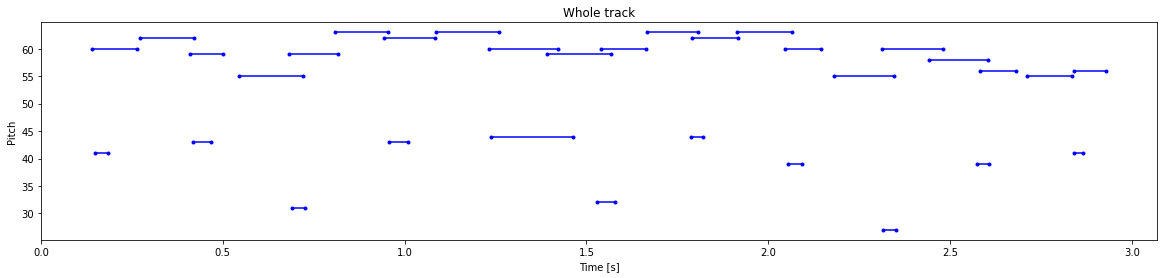

In [62]:
sample_song = normalizer.inverse_transform(x[2].numpy())
sample_song = pd.DataFrame(sample_song, columns=['pitch', 'step', 'duration'])
sample_song['pitch'] = sample_song['pitch'].round().clip(21, 108)
sample_song['step'] = sample_song['step'].clip(0)
sample_song['duration'] = sample_song['duration'].clip(.01)
sample_song['velocity'] = 77

sample_song_raw = notes_windowed_to_notes_raw(sample_song)
sample_song_midi = notes_to_midi(sample_song_raw, 0, False)
plot_piano_roll(sample_song_raw)
display_audio(sample_song_midi)

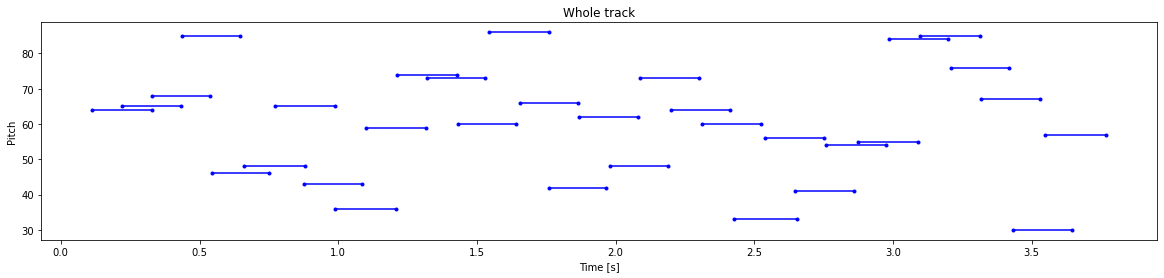

In [63]:
songs_reconstructed = vae.reconstruct_songs(x)
song_reconstructed = pd.DataFrame(songs_reconstructed[2], columns=['pitch', 'step', 'duration'])
song_reconstructed['velocity'] = 77

song_reconstructed_raw = notes_windowed_to_notes_raw(song_reconstructed)
song_reconstructed_midi = notes_to_midi(song_reconstructed_raw, 0, False)
plot_piano_roll(song_reconstructed_raw)
display_audio(song_reconstructed_midi)

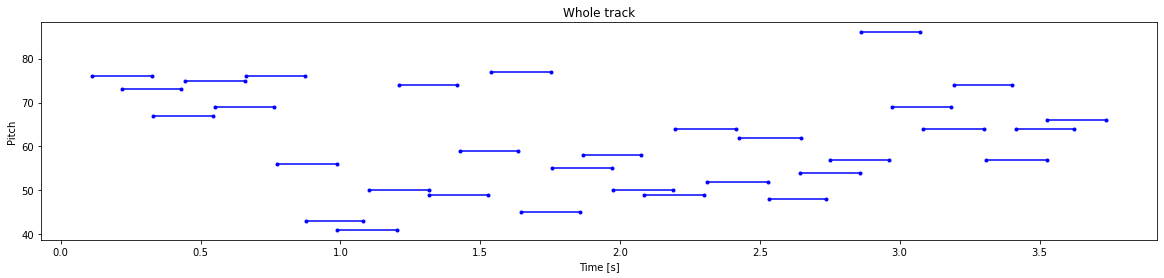

In [64]:
song_generated = pd.DataFrame(vae.generate_songs()[0], columns=['pitch', 'step', 'duration'])
song_generated['velocity'] = 77

song_generated_raw = notes_windowed_to_notes_raw(song_generated)
song_generated_midi = notes_to_midi(song_generated_raw, 0, False)

plot_piano_roll(song_generated_raw)
display_audio(song_generated_midi)

In [67]:
songs_generated = vae.generate_songs()[:5]

for s in range(songs_generated.shape[0]):
    
    song = songs_generated[s]
    song = pd.DataFrame(song, columns=['pitch', 'step', 'duration'])
    song['velocity'] = 77

    song_raw = notes_windowed_to_notes_raw(song)
    song_midi = notes_to_midi(song_raw, 0, False)
    
    midi_path = VAE_OUTPUT + f'generated_{s+1}.mid'
    song_midi.write(midi_path)
    

## Hierarchal Variational Autoencoder

This VAE is based on MusicVAE.

In [21]:
class MelodyGenerator():
    
    def __init__(self, _data, sequence_length, num_melody_sequences, batch_size, seed=None):
        
        X_cols = ['pitch', 'step', 'duration']
        Y_cols = ['pitch_digitized', 'step', 'duration']
        
        song_beginning = _data['song_beginning'].to_numpy()

        self.X = np.array(_data[X_cols])
        self.Y = np.array(_data[Y_cols])
        
        self.p_x = self.X.shape[-1]
        self.p_y = self.Y.shape[-1]
        
        self.sequence_length = sequence_length
        self.num_melody_sequences = num_melody_sequences
        
        self.output_total_length = self.num_melody_sequences * self.sequence_length
        
        self.batch_size = batch_size
        self.seed = seed
                        
        # Subset data
        def get_if_t_is_usable(t):

            c1 = t < len(song_beginning) - self.output_total_length - 1
            c2 = song_beginning[t] == 0
            return c1 and c2 and song_beginning[t + self.output_total_length - 1] == 0

        self.data_indices = np.array([ t for t in range(len(song_beginning)) if get_if_t_is_usable(t) ])
        self.n = len(self.data_indices)
        
        self.total_observations_per_epoch = self.n - (self.n % self.batch_size)
        self.num_batches_per_epoch =  self.total_observations_per_epoch // self.batch_size
        
        self.batch_beg_id = 0
        self.batch_end_id = self.batch_size
                
    def __iter__(self):
        
        if self.seed is not None:
            np.random.seed(self.seed)
            
        while True:
            
            if self.batch_beg_id == 0:                
                np.random.shuffle(self.data_indices)
               
            # This batch's inputs' beginning row numbers in self.data
            x_starts = self.data_indices[self.batch_beg_id : self.batch_end_id]
            
            # This batch's inputs' ending row numbers in self.data
            x_ends = x_starts + self.output_total_length
                             
            batch_x = np.stack([ self.X[x_start:x_end, :] for x_start, x_end in zip(x_starts, x_ends) ])
            batch_y = np.stack([ self.Y[x_start:x_end, :] for x_start, x_end in zip(x_starts, x_ends) ])
                                            
            self.batch_beg_id += self.batch_size
            self.batch_end_id += self.batch_size
            
            if self.batch_end_id >= self.total_observations_per_epoch:
                self.batch_beg_id = 0
                self.batch_end_id = self.batch_size
                
            yield tf.constant(batch_x), tf.constant(batch_y)
            
    def __call__(self):
        return self.__iter__()
        

In [34]:
VAE_TRAINING_NUM_SUB_GENERATORS = 20
VAE_VALIDATION_NUM_SUB_GENERATORS = 3
VAE_NUM_MELODY_SEQUENCES = 4
VAE_SEQUENCE_LENGTH = 8

vae_melody_gen_base_args = {'sequence_length': VAE_SEQUENCE_LENGTH, 
                            'num_melody_sequences': VAE_NUM_MELODY_SEQUENCES, 
                            'batch_size': BATCH_SIZE
                           }

vae_melody_gen_output_signature = (
    tf.TensorSpec(shape=(BATCH_SIZE, VAE_NUM_MELODY_SEQUENCES*VAE_SEQUENCE_LENGTH, len(KEYS)-1)),
    tf.TensorSpec(shape=(BATCH_SIZE, VAE_NUM_MELODY_SEQUENCES*VAE_SEQUENCE_LENGTH, len(KEYS)-1))
)

vae_melody_training_sub_generators = [MelodyGenerator(training_df, seed=11*i, **vae_melody_gen_base_args)
                                      for i in range(VAE_TRAINING_NUM_SUB_GENERATORS)
                                     ]

vae_melody_training_card = vae_melody_training_sub_generators[0].n // BATCH_SIZE

vae_training_sampler_generator = SamplerGenerator(vae_melody_training_sub_generators)

vae_melody_training_ds = (tf.data.Dataset
                          .from_generator(vae_training_sampler_generator, output_signature=vae_melody_gen_output_signature)
                          .cache()
                          .prefetch(tf.data.AUTOTUNE)
                          .apply(tf.data.experimental.assert_cardinality(vae_melody_training_card))
                         )

vae_melody_validation_sub_generators = [MelodyGenerator(validation_df, seed=13*i, **vae_melody_gen_base_args)
                                        for i in range(VAE_VALIDATION_NUM_SUB_GENERATORS)]

vae_melody_validation_card = vae_melody_training_sub_generators[0].n // BATCH_SIZE

vae_validation_sampler_generator = SamplerGenerator(vae_melody_validation_sub_generators)

vae_melody_validation_ds = (tf.data.Dataset
                            .from_generator(vae_validation_sampler_generator, 
                                            output_signature=vae_melody_gen_output_signature)
                            .cache()
                            .prefetch(tf.data.AUTOTUNE)
                            .apply(tf.data.experimental.assert_cardinality(vae_melody_validation_card))
                           )

In [35]:
%%time
x = None
batches_to_take = 500
for _ in vae_melody_training_ds.take(batches_to_take):
    x = _
    
print('element x batch shape: ', x[0].shape)
print('element y batch shape: ', x[1].shape, '\n')

print(f'first 10 rows of first melody of {batches_to_take}th x')
print(x[0].numpy()[0, :10, :], '\n')

print(f'first 10 rows of first melody of {batches_to_take}th y')
print(x[1].numpy()[0, :10, :], '\n')

print('To take 500 elements...')

element x batch shape:  (32, 32, 3)
element y batch shape:  (32, 32, 3) 

first 10 rows of first melody of 500th x
[[-1.2084943   0.85797435  3.8975122 ]
 [-3.023173   -0.32137105 -0.3222819 ]
 [-1.8133872  -0.41922066  3.73178   ]
 [-2.1158338  -0.4295206   3.9995012 ]
 [-2.7207265  -0.40377071 -0.33503053]
 [-3.9305124   1.9137203  -0.35734063]
 [-3.023173    5.080958   -0.40514797]
 [-2.7207265  -0.39347076 -0.39239934]
 [-1.2084943   0.703475    3.8847635 ]
 [-2.87195    -0.326521   -0.36690208]] 

first 10 rows of first melody of 500th y
[[48.          0.85797435  3.8975122 ]
 [24.         -0.32137105 -0.3222819 ]
 [40.         -0.41922066  3.73178   ]
 [36.         -0.4295206   3.9995012 ]
 [28.         -0.40377071 -0.33503053]
 [12.          1.9137203  -0.35734063]
 [24.          5.080958   -0.40514797]
 [28.         -0.39347076 -0.39239934]
 [48.          0.703475    3.8847635 ]
 [26.         -0.326521   -0.36690208]] 

To take 500 elements...
Wall time: 227 ms


In [24]:
class FeedbackLSTM(tf.keras.layers.Layer):
    
    def __init__(self, out_steps, units, concatenate_seed_input, name, activation='tanh'):
        super(FeedbackLSTM, self).__init__(name=name)
        
        self.units = units
        self.out_steps = out_steps
        self.concatenate_seed_input = concatenate_seed_input
        
        self.lstm_cells = [LSTMCell(self.units, activation=activation) for _ in range(self.out_steps)]
                        
    def call(self, seed_input, initial_states, training=True):
        
        assert not self.concatenate_seed_input or seed_input.shape[1] == self.units
                
        # seed_input.shape = (batch_size, self.units)
        # initial_state is shape [(batch_size, self.units)]*2
        
        cell_outputs = [None] * self.out_steps
                    
        cell_output, state = self.lstm_cells[0](seed_input, initial_states, training)
        cell_outputs[0] = cell_output

        for step in range(1, self.out_steps):
            
            input_tensor = cell_output

            if self.concatenate_seed_input:
                input_tensor = tf.concat([input_tensor, seed_input], axis=-1)

            cell_output, state = self.lstm_cells[step](input_tensor, state, training)
            cell_outputs[step] = cell_output

        return tf.stack(cell_outputs, axis=1)

In [25]:
class HierarchalVAE(tf.keras.Model):
    
    def __init__(self, training_data_element_spec, latent_dim, x_num_sequences, scaler=normalizer):
        super(HierarchalVAE, self).__init__()
                
        self.batch_size, self.x_length, self.num_input_keys = training_data_element_spec[0].shape
        self.x_size = self.x_length * self.num_input_keys
        self.x_num_sequences = x_num_sequences
        self.x_sequence_length = int(self.x_length / self.x_num_sequences)
        
        self.scaler = scaler
            
        assert self.x_length % self.x_num_sequences == 0
    
        self.k = latent_dim
        
        self.num_output_keys = 90
                        
        encoder_lstm_units = 256
        
        encoder_input = Input(shape=(self.x_length, self.num_input_keys), name='encoder_input')        
        
        encoder_lstm = Bidirectional(LSTM(encoder_lstm_units, activation='tanh',), name='encoder_lstm')(encoder_input)
        
        encoder_mu = Dense(self.k, activation='linear', name='encoder_mu')(encoder_lstm)
        encoder_log_sigma = Dense(self.k, activation='linear', name='encoder_log_sigma')(encoder_lstm)
        
        latent_vector = Input(shape=(self.k), name='latent_vector')
        
        conductor_initial_states = Dense(
            2*self.num_output_keys, activation='tanh', name='conductor_initial_states'
        )(latent_vector)
        
        conductor_initial_memory_state = Lambda(
            lambda x: x[:, :self.num_output_keys], name='conductor_initial_memory_state'
        )(conductor_initial_states)
        
        conductor_initial_carry_state = Lambda(
            lambda x: x[:, self.num_output_keys:], name='conductor_initial_carry_state'
        )(conductor_initial_states)
        
        conductor = FeedbackLSTM(
            out_steps=self.x_num_sequences, units=self.num_output_keys, name='conductor', concatenate_seed_input=False
        )(latent_vector, [conductor_initial_memory_state, conductor_initial_carry_state])       
        
        conductor_embedding_vectors = [
            Lambda(lambda x: x[:, s, :], name=f'conductor_embedding_vector_{s+1}')(conductor)
            for s in range(self.x_num_sequences)
        ]        
        
        decoder_initial_states_concat = [
            Dense(2*self.num_output_keys, activation='tanh', name=f'decoder_initial_states_{s+1}')(embedding_vector)
            for s, embedding_vector in enumerate(conductor_embedding_vectors)
        ]
        
        decoder_initial_states_split = [
            (Lambda(lambda x: x[:, :self.num_output_keys], name=f'decoder_{s+1}_initial_memory')(initial_state_concat),
             Lambda(lambda x: x[:, self.num_output_keys:], name=f'decoder_{s+1}_initial_carry')(initial_state_concat)
            )
            for s, initial_state_concat in enumerate(decoder_initial_states_concat)
        ]
                
        decoder_outputs = [
            FeedbackLSTM(self.x_sequence_length, self.num_output_keys, True, f'decoder_{s+1}', 'linear')
            (embedding_vector, initial_states)
            for s, (embedding_vector, initial_states) 
            in enumerate( zip(conductor_embedding_vectors, decoder_initial_states_split) )
        ]
                        
        model_output = Concatenate(axis=1, name='model_output')(decoder_outputs)
        
        self.encoder = tf.keras.Model(encoder_input, [encoder_mu, encoder_log_sigma], name='encoder')
        self.decoder = tf.keras.Model(latent_vector, model_output, name='decoder')
        
        self.sparse_crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=tf.keras.losses.Reduction.NONE
        )
            
    def sample_and_reparameterize(self, mu_log_sigma, n_samples=1):
        
        mu, log_sigma = mu_log_sigma
        sigma = tf.exp(log_sigma)
        
        b, k = mu.shape
        
        if n_samples == 1:      
            eps = tf.random.normal(shape=(b, k))
            return eps * sigma + mu
        else:
            eps = tf.random.normal(shape=(b, k))
            return [eps * sigma + mu for n in range(n_samples)]    
        
    def mse_with_positive_pressure(self, y_true, y_pred, pressure_factor=10):
        
        mse = (y_true - y_pred) ** 2
        positive_pressure = pressure_factor * tf.maximum(y_pred, 0)
        return mse + positive_pressure
        
    def reconstruction_loss(self, x, x_hat):
        
        pitch_loss = self.sparse_crossentropy(x[:, :, 0], x_hat[:, :, :88])
        pitch_loss = tf.reduce_mean( pitch_loss, axis=[0, 1]) # <-- mean cross-entropy for batch
        
        #step_loss = self.mse_with_positive_pressure (x[:, :, 1], x_hat[:, :, 88] )
        step_loss = (x[:, :, 1] - x_hat[:, :, 88]) ** 2
        step_loss = tf.reduce_mean( step_loss, axis=[0, 1] )
        
        #duration_loss = self.mse_with_positive_pressure( x[:, :, 2], x_hat[:, :, 89], .01 )
        duration_loss = (x[:, :, 1] - x_hat[:, :, 89]) ** 2
        duration_loss = tf.reduce_mean( duration_loss, axis=[0, 1] )
        
        return .05 * pitch_loss + step_loss + duration_loss
    
    def kl_divergence(self, mu_z, log_sigma_z):
        
        kl = tf.exp(log_sigma_z) + tf.square(mu_z) - 1 - log_sigma_z
        return tf.reduce_mean(.5 * tf.reduce_sum(kl, axis=1), axis=0)
    
    def recon_plus_kl(self, x1_x2):
        
        mu_z, log_sigma_z = self.encoder(x1_x2[0])
        z = self.sample_and_reparameterize([mu_z, log_sigma_z])
        x_hat = self.decoder(z)
        
        reconstruction_loss = self.reconstruction_loss(x1_x2[1], x_hat)
        kl_divergence = self.kl_divergence(mu_z, log_sigma_z)
        
        return reconstruction_loss + kl_divergence
    
    def compute_loss(self, x1_x2):
        return self.recon_plus_kl(x1_x2)
    
    def compile(self, optimizer=tf.keras.optimizers.Adam(1e-3)):
        super(HierarchalVAE, self).compile()
        
        self.optimizer = optimizer
        
        self.encoder.compile(optimizer=optimizer, loss=None)
        self.decoder.compile(optimizer=optimizer, loss=None)
        
    def call(self, inputs, is_training=False):
        
        inputs_is_list = isinstance(inputs, list)
        
        if inputs_is_list and is_training:
            return [self.train_step(x1_x2) for x1_x2 in inputs]
        
        elif inputs_is_list and not is_training:
            return [self.reconstruct_songs(x1_x2) for x1_x2 in inputs]
        
        elif not inputs_is_list and is_training:
            return self.train_step(inputs)
        
        elif not inputs_is_list and not is_training:
            return self.reconstruct_songs(inputs)
        
    def train_step(self, x1_x2):
        
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x1_x2)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}
    
    def test_step(self, x):
        
        loss = self.compute_loss(x)
        return {'loss': loss}
    
    def save(self, model_dir):
        
        if model_dir[-1] != '/':
            model_dir += '/'
        
        encoder_save_path = model_dir + 'encoder'
        decoder_save_path = model_dir + 'decoder'
        
        tf.keras.models.save_model(self.encoder, encoder_save_path)
        tf.keras.models.save_model(self.decoder, decoder_save_path)
        
    def count_params(self):
        return self.encoder.count_params() + self.decoder.count_params()
        
    def reconstruct_songs(self, songs, temperature=1, argmax=False):
        
        mu_z, log_sigma_z = self.encoder(songs)
        z = self.sample_and_reparameterize([mu_z, log_sigma_z])
        x_hat = self.decoder(z).numpy()
                
        pitch_logits = x_hat[:, :, :88]
        pitches = self.sample_pitches_from_batch(pitch_logits, temperature, argmax)    
        
        step = x_hat[:, :, 88:89]
        duration = x_hat[:, :, 89:90]

        songs = np.concatenate([pitches, step, duration], axis=-1)
        
        if self.scaler is not None:
            for s in range(songs.shape[0]):            
                scaled_values = self.scaler.inverse_transform(songs[s])
                songs[s, :, 1] = scaled_values[:, 1]
                songs[s, :, 2] = scaled_values[:, 2]
                
        songs[:, :, 1] = np.maximum(songs[:, :, 1], 0)
        songs[:, :, 2] = np.maximum(songs[:, :, 2], .01)
        
        return songs
    
    def sample_pitches_from_batch(self, logits, temperature=1, argmax=False):

        # logits.shape = [batch_size, sequence_length, num_output_keys]
        # output.shape = [batch_size, sequence_length, 1]
        
        logits /= temperature
        
        if argmax:
            pitches = np.apply_along_axis(np.argmax, 2, logits)
            pitches = np.expand_dims(pitches, -1)
            return pitches + 21
        
        else:
            song_pitches = [tf.random.categorical(logits[b], num_samples=1).numpy() for b in range(logits.shape[0])]
            pitches = np.stack(song_pitches, axis=0)
            return pitches + 21
            
    def generate_songs(self, temperature=1, argmax=False):
                
        z = tf.random.normal(shape=(self.batch_size, self.k))
        x = self.decoder(z).numpy()

        pitch_logits = x[:, :, :88]
        pitches = self.sample_pitches_from_batch(pitch_logits, temperature, argmax)

        step = x[:, :, 88:89]
        duration = x[:, :, 89:90]
        
        songs = np.concatenate([pitches, step, duration], axis=-1)
        
        if self.scaler is not None:
            for s in range(songs.shape[0]):            
                scaled_values = self.scaler.inverse_transform(songs[s])
                songs[s, :, 1] = scaled_values[:, 1]
                songs[s, :, 2] = scaled_values[:, 2]
                
        songs[:, :, 1] = np.maximum(songs[:, :, 1], 0)
        songs[:, :, 2] = np.maximum(songs[:, :, 2], .01)
        
        return songs
    

In [29]:
vae = HierarchalVAE(vae_melody_training_ds.element_spec, 32, 4, normalizer)
vae.compile()
vae_total_trained_epochs = 0

In [107]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 100, 3)]     0           []                               
                                                                                                  
 encoder_lstm (Bidirectional)   (None, 512)          532480      ['encoder_input[0][0]']          
                                                                                                  
 encoder_mu (Dense)             (None, 32)           16416       ['encoder_lstm[0][0]']           
                                                                                                  
 encoder_log_sigma (Dense)      (None, 32)           16416       ['encoder_lstm[0][0]']           
                                                                                            

In [30]:
vae.decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_vector (InputLayer)     [(None, 32)]         0           []                               
                                                                                                  
 conductor_initial_states (Dens  (None, 180)         5940        ['latent_vector[0][0]']          
 e)                                                                                               
                                                                                                  
 conductor_initial_memory_state  (None, 90)          0           ['conductor_initial_states[0][0]'
  (Lambda)                                                       ]                                
                                                                                            

In [31]:
num_training_files_str = f'{training_df.shape[0]}_files_'

vae_early_stop_ckpt_clbk = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=4, restore_best_weights=False, verbose=0
)

vae_reduce_lr_clbk = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=.1)

vae_callbacks = [vae_reduce_lr_clbk, vae_early_stop_ckpt_clbk]

In [ ]:
%%time

epochs = 5

absl.logging.set_verbosity(absl.logging.ERROR)

vae_history = vae.fit(vae_melody_training_ds, epochs=epochs, #steps_per_epoch=200, 
                      #validation_data=vae_melody_validation_ds, validation_steps=VALIDATION_STEPS_PER_EPOCH,
                      callbacks=vae_callbacks
                     ).history

vae_total_trained_epochs += len(vae_history['loss'])
last_loss = round(vae_history['loss'][-1], 3)

num_training_files_str = f'{num_training_files}_files_'
num_params_str = f'{vae.count_params()}_params_'
epochs_str = f'{vae_total_trained_epochs:03d}_epochs_'
loss_str = f'{last_loss}_loss'
model_name = num_training_files_str + num_params_str + epochs_str + loss_str

vae_save_path = VAE_RNN_HIERARCHAL_DIR + model_name
vae.save(vae_save_path)

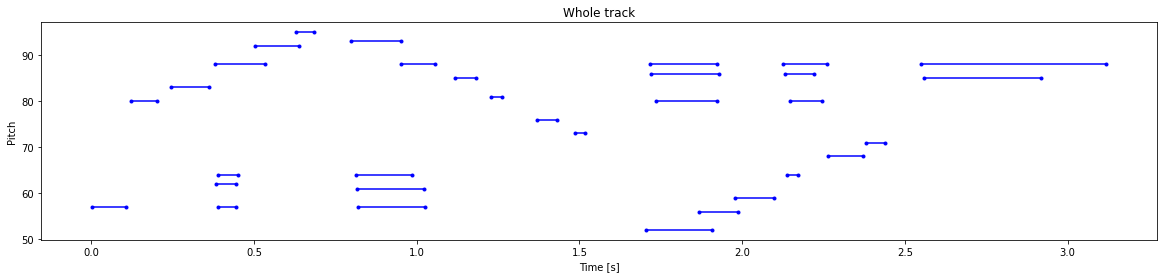

In [42]:
song_sample = x[0][30]
song_sample = normalizer.inverse_transform(song_sample)
song_sample = pd.DataFrame(song_sample, columns=['pitch', 'step', 'duration'])
song_sample['pitch'] = (song_sample['pitch'].round() + 21).clip(21, 108)
song_sample['step'] = song_sample['step'].clip(0)
song_sample['duration'] = song_sample['duration'].clip(0)
song_sample['velocity'] = 77

song_sample_raw = notes_windowed_to_notes_raw(song_sample)
song_sample_midi = notes_to_midi(song_sample_raw, 0, False)

plot_piano_roll(song_sample_raw)
display_audio(song_sample_midi)

In [43]:
songs_reconstructed = vae.reconstruct_songs(x[0])
song_reconstructed = pd.DataFrame(songs_reconstructed[0], columns=['pitch', 'step', 'duration'])
song_reconstructed['velocity'] = 77

song_reconstructed.describe().loc[['mean', 'std', 'min', 'max']]

,pitch,step,duration,velocity
mean,59.343750,0.109835,0.212245,77.0
std,19.100092,0.000237,0.000450,0.0
min,21.000000,0.109182,0.211024,77.0
max,88.000000,0.110551,0.213483,77.0


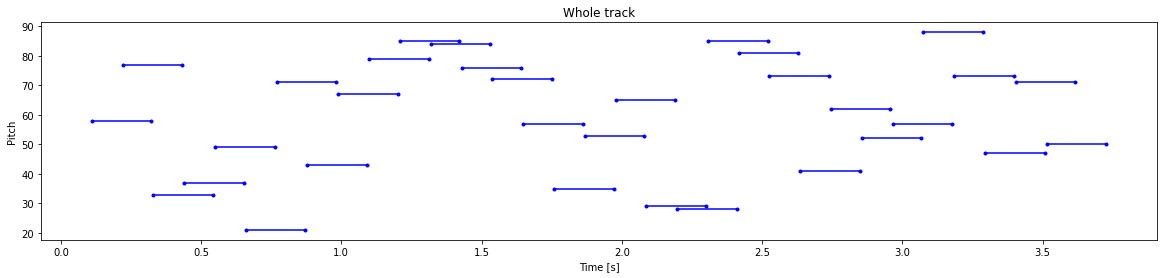

In [44]:
song_reconstructed_raw = notes_windowed_to_notes_raw(song_reconstructed)
song_reconstructed_midi = notes_to_midi(song_reconstructed_raw, False, 0)

plot_piano_roll(song_reconstructed_raw)
display_audio(song_reconstructed_midi)

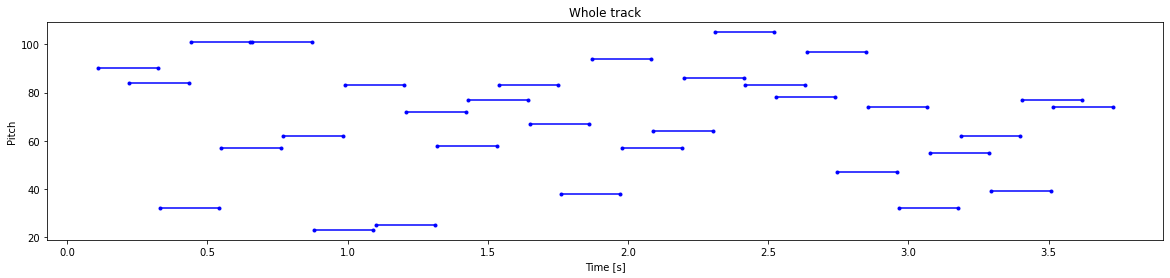

In [47]:
song_generated = vae.generate_songs()[0]
song_generated = pd.DataFrame(song_generated, columns=['pitch', 'step', 'duration'])
song_generated['velocity'] = 77

song_generated_raw = notes_windowed_to_notes_raw(song_generated)
song_generated_midi = notes_to_midi(song_generated_raw, 0, False)

plot_piano_roll(song_generated_raw)
display_audio(song_generated_midi)

In [53]:
songs_generated = vae.generate_songs()[:5]

for s in range(songs_generated.shape[0]):
    
    song = songs_generated[s]
    song = pd.DataFrame(song, columns=['pitch', 'step', 'duration'])
    song['velocity'] = 77

    song_raw = notes_windowed_to_notes_raw(song)
    song_midi = notes_to_midi(song_raw, 0, False)
    
    midi_path = VAE_RNN_HIERARCHAL_OUTPUT + f'generated_{s+1}.mid'
    song_midi.write(midi_path)
    